In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms, models

import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
transform = transforms.Compose([transforms.Resize(size=(224,224)), transforms.ToTensor()])

trainset = datasets.ImageFolder('./flower_photos/train/', transform=transform)
validset = datasets.ImageFolder('./flower_photos/test/', transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
validloader = torch.utils.data.DataLoader(validset, batch_size=32, shuffle=True)

classes = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

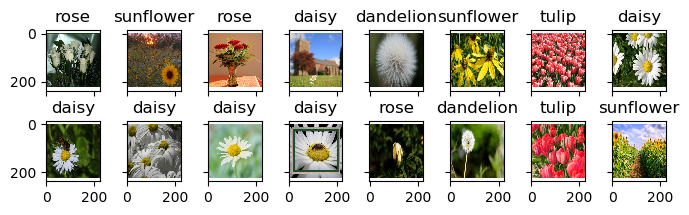

In [3]:
fig, ax = plt.subplots(2,8, figsize=(8,2), dpi=100, sharex=True, sharey=True)
train_images, train_labels = next(iter(trainloader))
valid_images, valid_labels = next(iter(validloader))
for i in range(ax.shape[1]):
    image = train_images[i,:,:,:].numpy().transpose((1,2,0))
    label = classes[train_labels[i].numpy()]
    ax[0,i].imshow(image)
    ax[0,i].set_title(label)
    image = valid_images[i,:,:,:].numpy().transpose((1,2,0))
    label = classes[valid_labels[i].numpy()]
    ax[1,i].imshow(image)
    ax[1,i].set_title(label)
# 
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

In [4]:
model = models.vgg16(pretrained=True)
for param in model.features.parameters():
    param.require_grad = False
#     
# from collections import OrderedDict
# classifier = nn.Sequential(OrderedDict([
#     ('fc1', nn.Linear(25088, 1024)),
#     ('relu1', nn.ReLU()),
#     ('dropout', nn.Dropout(0.5)),
#     ('fc2', nn.Linear(1024, 5))
# ]))
# model.classifier = classifier

output_layer = nn.Linear(4096, 5)
model.classifier[6] = output_layer

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:06<00:00, 90338906.28it/s] 


In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [6]:
def compute_accurcay(output, labels):
    output = output.argmax(dim=1)
    output = output.view(*labels.shape)
    equals = (output == labels).float()
    return float(torch.mean(equals))

In [7]:
def train(model, trainloader, validloader, n_epochs=1):
    # Send model to GPU(s), if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model)
    model = model.to(device)
    
    # Initialize losses and accuracies
    train_losses, valid_losses = [], [] # Train and test losses
    train_accs, valid_accs = [], [] # Train and test accuracies
    min_valid_loss = np.infty
    history = {}
    
    for iepoch in range(n_epochs):
        '''Training'''
        train_loss, train_acc = 0, 0
        for itrain, (images, labels) in enumerate(trainloader):
            # Display progress
            progress_percent = (itrain+1)/len(trainloader)*100
            progress_bar = ['.']*int(progress_percent/(len(trainloader)/100))
            
            sys.stdout.write('\rEpoch: {}/{}..'.format(iepoch+1, n_epochs) \
                             +'Progress: {:0.2f}%..'.format(progress_percent))
            sys.stdout.flush()
            
            # Send data to device (GPU is available, CPU else)
            images, labels = images.to(device), labels.to(device)
            
            # Model training
            optimizer.zero_grad() # Refresh gradient for backpropagation
            output = model(images) # Forward pass
            loss = criterion(output, labels)            
            loss.backward() # Backpropagation
            optimizer.step() # Update parameters
            
            # Accumulate loss and accuracy for every batch
            train_loss += loss.item()
            train_acc += compute_accurcay(output, labels)
        # Record losses and accuracies for every epoch
        train_losses.append(train_loss/len(trainloader))
        train_accs.append(train_acc/len(trainloader))

        '''Validation'''
        valid_loss, valid_acc = 0, 0
        with torch.no_grad():
            model.eval() # Disable dropout (if any) for prediction
            for images, labels in validloader:
                # Send data to GPU or CPU
                images, labels = images.to(device), labels.to(device)
                # Predict class probabilities and loss
                output = model(images)
                loss = criterion(output, labels)
                # Accumulate loss and accuracy
                valid_acc += compute_accurcay(output, labels)
                valid_loss += loss.item()
        # Record losses and accuracies
        valid_losses.append(valid_loss/len(validloader))
        valid_accs.append(valid_acc/len(validloader))
        
        # Save model if current epoch gives minimum validation loss
        if valid_losses[iepoch] < min_valid_loss:
            history['model'] = model
        
         # Back to train mode by enabling dropout
        model.train()

        print('Training:',
              '(Loss={:0.3f},'.format(train_losses[iepoch]),
              'Accuracy={:0.3f})..'.format(train_accs[iepoch]),
              'Validation:',
              '(Loss={:.03f},'.format(valid_losses[iepoch]),
              'Accuracy={:0.3f})'.format(valid_accs[iepoch])
             )
    history['train_losses'] = train_losses
    history['valid_losses'] = valid_losses
    history['train_accs'] = train_accs
    history['valid_accs'] = valid_accs
    return history

In [8]:
history = train(model, trainloader, validloader, n_epochs=5)

Epoch: 1/5..Progress: 100.00%..Training: (Loss=1.595, Accuracy=0.270).. Validation: (Loss=1.394, Accuracy=0.371)
Epoch: 2/5..Progress: 100.00%..Training: (Loss=1.324, Accuracy=0.409).. Validation: (Loss=1.241, Accuracy=0.486)
Epoch: 3/5..Progress: 100.00%..Training: (Loss=1.209, Accuracy=0.483).. Validation: (Loss=1.134, Accuracy=0.520)
Epoch: 4/5..Progress: 100.00%..Training: (Loss=1.137, Accuracy=0.539).. Validation: (Loss=1.096, Accuracy=0.597)
Epoch: 5/5..Progress: 100.00%..Training: (Loss=1.061, Accuracy=0.572).. Validation: (Loss=1.028, Accuracy=0.566)


In [9]:
import pickle
with open('history.pkl') as p:
    pickle.dump(p, history)